In [7]:
!git clone https://github.com/icomse/5th_workshop_MachineLearning.git
import os
os.chdir('5th_workshop_MachineLearning/data')

fatal: destination path '5th_workshop_MachineLearning' already exists and is not an empty directory.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import sklearn 
%matplotlib inline

## Data Cleaning

In [34]:
cld=pd.read_csv('HCEPDB_100K_cleaned.csv') # change where it is

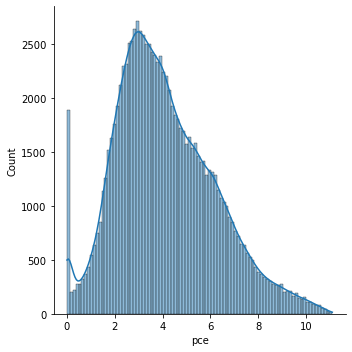

In [35]:
sns.displot(cld['pce'],kde=True)

Hmm.  Looks like those PCE entries at zero are probably errors.

In [36]:
cld = cld[cld['pce']!=0]

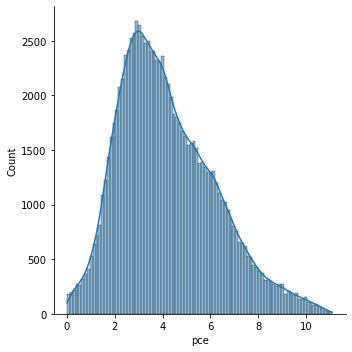

In [37]:
sns.displot(cld['pce'],kde=True)

There's a number of different ways to standardize data

In [38]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

There's a range of different ways to impute data in both scikit learn and pandas

In [39]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

## Validation Methods

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
%matplotlib inline

## Validation

We always want to minimize the MSE of the TEST dataset, not the error of the TRAINING dataset. 

When **training** a machine learning model, we split our dataset into a **training dataset** and a **test dataset**. The training dataset is used to train our machine learning model. The test dataset is used to verify the accuracy of our trained model. It is **very** important that the test dataset and training dataset are completely separate, otherwise you could overestimate the accuracy of your model.

We rarely have an indepedent test dataset. In practice, we will randomly split our sample dataset into a training dataset and test dataset. This process is called **validation**. Validation is typically used in two scenarios: **model selection** (choosing the proper level of flexibility) and **model assessment** (evaluating a model's performance). We will take a look at both use cases.
<img width="304" height="175" alt="Image result for training test dataset" src="http://scott.fortmann-roe.com/docs/docs/MeasuringError/holdout.png">

`scikit-learn` handily has a function that does this split for us. But first, let's create a datset that we can practice on using a regression model:

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

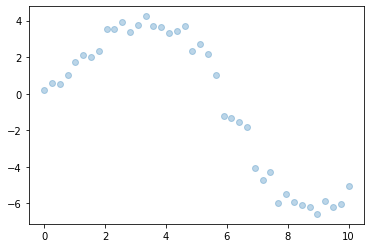

In [42]:
x = np.linspace(0, 10, 40)
# create some polynomial data with noise.
np.random.seed(80309)
noise_scale = 0.25
y = 0.2*x + 1*x**2 - 0.3*x**3 + 0.021*x**4 - 0.00018*x**5 +  noise_scale*np.random.rand(len(x))*(x+3)
plt.scatter(x, y, alpha=0.3)
plt.show()

In [43]:
#create some polynomial features we can fit to
X = pd.DataFrame()
ndegree = 20
for d in range(ndegree):
    X[f'x{d}'] = x**d 

We'll use validation to select the degree of flexibility of our linear model. First, the split:

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [45]:
reg = LinearRegression().fit(X_train[['x1']], y_train)
y_pred_test = reg.predict(X_test[['x1']])

Fit to just a simple line . . . not so great.

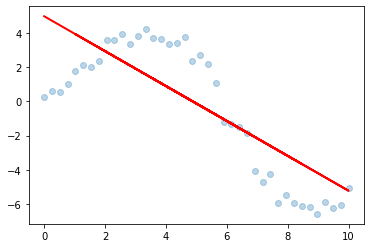

In [46]:
plt.scatter(x, y, alpha=0.3)
plt.plot(X_test[['x1']], y_pred_test, linewidth=2,color='r')
plt.show()

We can get a measure of the degree of quality of fit using the mean squared error:

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
mean_squared_error(y_test, y_pred_test)

5.531714095384354

Now, let's repeat the linear regression while increasing the degree of our polynomial, and plot the results

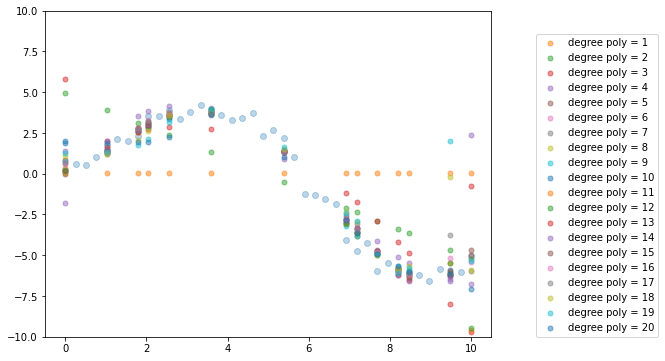

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.3)
npoly = len(X.columns)+1
mse_test = np.zeros(npoly)
mse_train = np.zeros(npoly)

# DISCUSS WHAT EACH LINE 
for i in range(1, npoly):
    reg = LinearRegression().fit(X_train[X_train.columns[:i]], y_train)    
    y_pred_train = reg.predict(X_train[X_test.columns[:i]])
    y_pred_test = reg.predict(X_test[X_test.columns[:i]])
    ax.scatter(X_test[['x1']], y_pred_test, marker='.',label="degree poly = "+str(i),s=100,alpha=0.5)    
    mse_test[i-1] = mean_squared_error(y_test, y_pred_test)
    mse_train[i-1] = mean_squared_error(y_train, y_pred_train)
ax.legend(loc=(1.1,0))
plt.ylim([-10,10])
plt.show()

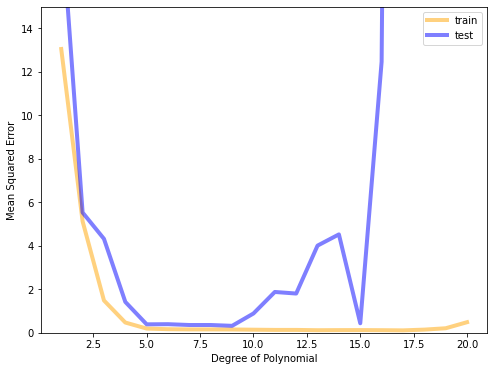

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(1, npoly-1,npoly-1), mse_train[:-1], linewidth=4,alpha=0.5,color='orange',label='train')
ax.plot(np.linspace(1, npoly-1,npoly-1), mse_test[:-1], linewidth=4, alpha=0.5,color='blue',label='test')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Degree of Polynomial')
ax.set_ylim([0,15])
plt.legend()
plt.show()

What is the difference is between the MSE of the test set and the training set?
Where would this data suggest we use as a degree of fit?

This validation method has two disadvantages:
    
* The test error is variable, depending on your training dataset. If we used a different training dataset, we'd have a different error
* We only use a subset of the training dataset to create our model. The fewer the observations, the worse the final model (we actually overestimate the test error rate!) What happens if we run a few times?

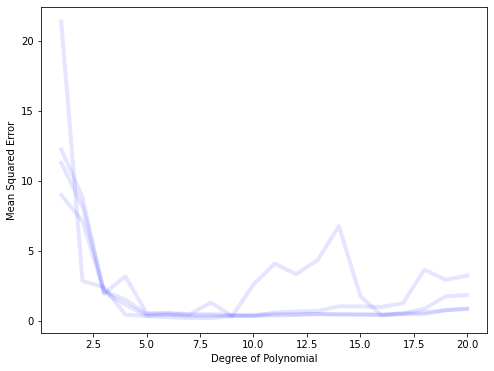

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
ntrials = 40
for run in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    mse = np.zeros(npoly)

    for i in range(1, npoly):
        reg = LinearRegression().fit(X_train[X_train.columns[0:i]], y_train)
        y_pred = reg.predict(X_test[X_test.columns[0:i]])

        mse[i-1] = mean_squared_error(y_test, y_pred)

    
    ax.plot(np.linspace(1, npoly-1,npoly-1), mse[:-1], linewidth=4, alpha=0.1, color ='b')
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Degree of Polynomial')

One common alternative to is **K-fold cross-validation**. In this approach, we split the original dataset into *k* units. In on training-test configuration, *k-1* of the units will be used as a training dataset, while the remaining unit will be used as a test dataset. We train a model *k* times, switching out the test dataset each time, and use the average error as an estimate of the actual test error.

<img width="608" height="334" alt="Image result for k-fold cross-validation" src="https://cdn-images-1.medium.com/max/1600/1*me-aJdjnt3ivwAurYkB7PA.png">

**Hacking Time**: Think about the below code, add a comment on what each line that uses the `Kfold` module does. . 

In [52]:
from sklearn.model_selection import KFold

number of splits = 10
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 29 31 32 33 34 35 36 37 38 39] TEST: [ 6 15 28 30]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 34 35 38] TEST: [33 36 37 39]
TRAIN: [ 1  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39] TEST: [ 0  2  7 24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 15 16 17 18 19 20 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39] TEST: [10 13 14 21]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24 25
 26 27 28 29 30 31 33 35 36 37 38 39] TEST: [ 5 23 32 34]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 18 19 21 22 23 24 25 26
 27 28 29 30 32 33 34 35 36 37 38 39] TEST: [ 8 17 20 31]
TRAIN: [ 0  1  2  3  5  6  7  8 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25 27
 28 29 30 31 32 33 34 35 36 37 38 39] TEST: [ 4  9 18 26]
TRAIN: [ 0  

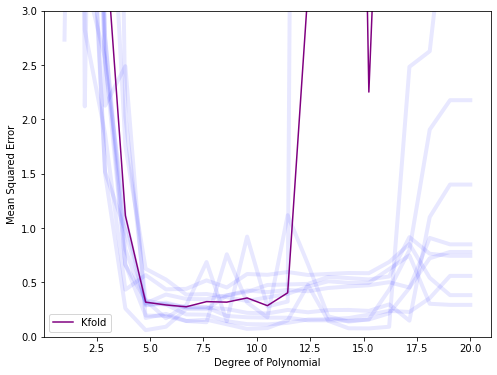

In [53]:
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True) 

# we need shuffle=True, since the data is ordered
print('number of splits =', kf.get_n_splits(X, y)) 

fig, ax = plt.subplots(figsize=(8,6))

mse = np.zeros((npoly, nfold))
j = 0
for train_index, test_index in kf.split(X, y):
    # what are train_index and test_index? You can comment out this line
    # below once you figure out
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for i in range(1, npoly+1):
        reg = LinearRegression().fit(X_train[X_train.columns[:i]], y_train)
        y_pred = reg.predict(X_test[X_test.columns[:i]])
        mse[i-1, j] = mean_squared_error(y_test, y_pred)

    ax.plot(np.linspace(1, npoly-1, npoly), mse[:, j], linewidth=4, color='b', alpha=0.09)
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Degree of Polynomial')
    j += 1
    
avg_mse = mse.mean(axis=1)
ax.plot(np.linspace(1, npoly-1, npoly), avg_mse, color='purple',label='Kfold')
ax.set_ylim([0,3])
plt.legend()
plt.show()

**Hacking time**: Trying perform hyperparameter tuning; running this process of looking at the the test MSE through with different numbers of 'folds', different numbers of data points, and with different amounts of noise (the variable `noise_scale` above. Try to break things!